# Dynamic Models of Buildings and HVAC Controllers

Based on the approach proposed by Patel et al. (2016):

- N. R. Patel, M. J. Risbeck, J. B. Rawlings, M. J. Wenzel and R. D. Turney, "Distributed economic model predictive control for large-scale building temperature regulation," 2016 American Control Conference (ACC), Boston, MA, USA, 2016, pp. 895-900, doi: 10.1109/ACC.2016.7525028. https://ieeexplore.ieee.org/document/7525028

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import casadi as cas

## Building Temperature Models

Single zone model

$$C \frac{dT}{dt} = -H(T-T_a) - \dot{Q}_c + \dot{Q}_\text{other}$$

Multi-zone model

$$
C_i \frac{dT_i}{dt} = -H_i(T_i - T_a) - \sum_{j \ne i}{\beta_{ij}(T_i-T_j)} - \dot{Q}_{c,i} + \dot{Q}_{\text{other},i} \qquad  i=1,\dots,n_z
$$

Model of zone temperature controller (PI)

$$\dot{Q}_{c}=\dot{Q}_{ss} + K_{c} \left[ \varepsilon + \frac{1}{\tau_\text{I}}\int_0^t{\varepsilon(t') dt'} \right]$$

$$ \varepsilon = T_{\text{sp}} - T $$

Continuous-time state space model:

$$\dot{\mathbf{x}}(t) = \mathbf{A}\mathbf{x}(t) + \mathbf{B}\mathbf{u}(t)$$

$$\dot{\mathbf{y}}(t) = \mathbf{C}\mathbf{x}(t) + \mathbf{D}\mathbf{u}(t)$$

## Simulate single zone with cooling and disturbance inputs

One state variable:

$$x(t) = T(t)$$

Three inputs:

$$\mathbf{u}(t) = \begin{bmatrix} Q_c \\ T_a \\ \dot{Q}_\text{other} \end{bmatrix}$$

In [2]:
# Constants
C = 450.0  # thermal capacitance, kJ/K
H = 15.0   # scaled heat transfer coefficient with ambient, kW/K

# System dimensions
nx = 1
nu = 3

# States
x = cas.MX.sym('x', nx)
u = cas.MX.sym('x', nu)

T = x  # zone temperature
Q_c = u[0]  # cooling delivered
T_a = u[1]  # ambient temperature
Q_other = u[2]  # external heat load, e.g. insolation or disturbance

# Define ODE
dTdt = (-H * (T - T_a) - Q_c + Q_other) / C  # rate-of-change of zone temperature

rhs = dTdt
f = cas.Function('f', [x, u], [rhs], ['x', 'u'], ['dxdt'])
print(f)

f:(x,u[3])->(dxdt) MXFunction


In [3]:
def convert_continuous_model_to_discrete(f, x, u, dt, number_of_finite_elements=1, solver='rk'):

    # Make integrator
    intg_options = {'number_of_finite_elements': number_of_finite_elements}
    dae = {'x': x, 'p': u, 'ode': f(x, u)}
    t0, tf = 0, dt / number_of_finite_elements
    intg = cas.integrator('intg', solver, dae, t0, tf, intg_options)

    # Discrete-time system model
    res = intg(x0=x, p=u)
    xf = res['xf']
    F = cas.Function('F', [x, u], [xf], ['xk', 'uk'], ['xkp1'])

    return F

# Construct discrete-time system model
dt = 0.25  # timestep size, hours
F = convert_continuous_model_to_discrete(f, x, u, dt)
print(F)

F:(xk,uk[3])->(xkp1) MXFunction


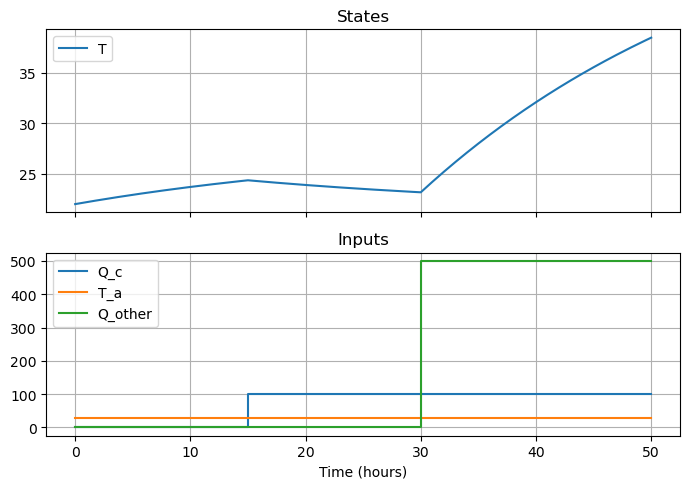

In [4]:
# Simulation inputs
nT = 200
t = dt * np.arange(nT+1)
U = np.zeros((nT+1, nu))
U[t >= 15, 0] = 100.0   # Q_c
U[:, 1] = 28.0  # T_a
U[t >= 30, 2] = 500.0   # Q_other

# Initial condition
x0 = 22.0  # zone temperature

def simulate_system(F, U, nx, x0):
    nT = U.shape[0] - 1
    X = np.full((nT+1, nx), np.nan)
    xk = x0
    for k in range(nT+1):
        X[k, :] = np.array(xk).reshape(-1)
        uk = U[k, :].T
        xk = F(xk, uk)
    return X

# Simulation loop
X = simulate_system(F, U, nx, x0)

# Plot results
def make_inputs_states_plot(t, X, U, figsize=(7, 5), x_labels=None, 
                            u_labels=None, time_label="Time (hours)"):
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=figsize)
    ax = axes[0]
    ax.plot(t, X)
    ax.grid()
    ax.legend(x_labels)
    ax.set_title('States')
    ax = axes[1]
    ax.step(t, U, where='post')
    ax.set_xlabel(time_label)
    ax.grid()
    ax.legend(u_labels)
    ax.set_title('Inputs')
    return fig, axes

make_inputs_states_plot(t, X, U, x_labels=['T'], u_labels=['Q_c', 'T_a', 'Q_other'])
plt.tight_layout()
plt.show()

## Simulate single zone with cooling, disturbance inputs and proportional controller

One state variable:

$$x(t) = T(t)$$

Three inputs:

$$\mathbf{u}(t) = \begin{bmatrix} T_{sp} \\ T_a \\ \dot{Q}_\text{other} \end{bmatrix}$$

In [5]:
# Constants
C = 450.0  # thermal capacitance, kJ/K
H = 15.0   # scaled heat transfer coefficient with ambient, kW/K
K_c = -560  # controller gain parameter
Q_ss = 0    # steady-state rate of cooling

# System dimensions
nx = 1
nu = 3

# States
x = cas.MX.sym('x', nx)
u = cas.MX.sym('x', nu)

T = x  # zone temperature
T_sp = u[0]  # zone temperature setpoint
T_a = u[1]  # ambient temperature
Q_other = u[2]  # external heat load, e.g. insolation or disturbance

# Define ODE
eps = T_sp - T  # tracking error
Q_c = Q_ss + K_c * eps  # control action
dTdt = (-H * (T - T_a) - Q_c + Q_other) / C  # rate-of-change of zone temperature

rhs = dTdt
f = cas.Function('f', [x, u], [rhs], ['x', 'u'], ['dxdt'])
print(f)

f:(x,u[3])->(dxdt) MXFunction


In [6]:
# Construct discrete-time system model
dt = 0.25  # timestep size, hours
F = convert_continuous_model_to_discrete(f, x, u, dt)
print(F)

F:(xk,uk[3])->(xkp1) MXFunction


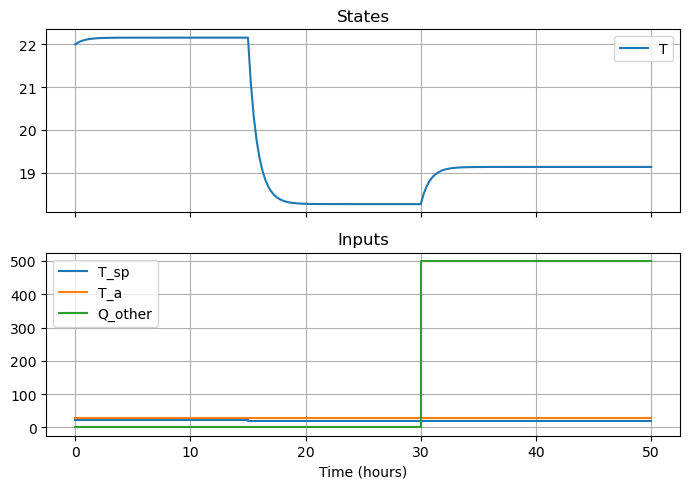

In [7]:
# Simulation inputs
nT = 200
t = dt * np.arange(nT+1)
X = np.full((nT+1, nx), np.nan)
U = np.zeros((nT+1, nu))
U[:, 0] = 22.0   # T_sp
U[t >= 15, 0] = 18.0   # T_sp
U[:, 1] = 28.0  # T_a
U[t >= 30, 2] = 500.0   # Q_other

# Initial condition
x0 = 22.0  # zone temperature

# Simulation loop
X = simulate_system(F, U, nx, x0)

# Plot results
make_inputs_states_plot(t, X, U, x_labels=['T'], u_labels=['T_sp', 'T_a', 'Q_other'])
plt.tight_layout()
plt.show()

In [8]:
rmse_tracking = np.sqrt(np.mean((X[:, 0] - U[:, 0]) ** 2))
print(f"Tracking error: {rmse_tracking:.2f}")

Tracking error: 0.84


## Simulate single zone with cooling, disturbance inputs and PI controller

State variables:

$$\mathbf{x}(t) = \begin{bmatrix} T(t) \\ \bar{\varepsilon}(t) \end{bmatrix}$$

Three inputs:

$$\mathbf{u}(t) = \begin{bmatrix} T_{sp} \\ T_a \\ \dot{Q}_\text{other} \end{bmatrix}$$

In [9]:
# Constants
C = 450.0  # thermal capacitance, kJ/K
H = 15.0   # scaled heat transfer coefficient with ambient, kW/K
K_c = -560  # controller gain parameter
tau_I = 1   # PI controller integral parameter
Q_ss = 0    # steady-state rate of cooling

# System dimensions
nx = 2
nu = 3

# States
x = cas.MX.sym('x', nx)
u = cas.MX.sym('x', nu)

T = x[0]  # zone temperature
I_eps = x[1]  # integral of tracking error
T_sp = u[0]  # zone temperature setpoint
T_a = u[1]  # ambient temperature
Q_other = u[2]  # external heat load, e.g. insolation or disturbance

# Define ODE
eps = T_sp - T  # tracking error
dI_eps_dt = eps
Q_c = Q_ss + K_c * (eps + I_eps / tau_I)  # control action
dTdt = (-H * (T - T_a) - Q_c + Q_other) / C  # rate-of-change of zone temperature

rhs = cas.vertcat(dTdt, dI_eps_dt)
f = cas.Function('f', [x, u], [rhs], ['x', 'u'], ['dxdt'])
print(f)

f:(x[2],u[3])->(dxdt[2]) MXFunction


In [10]:
# Construct discrete-time system model
dt = 0.25  # timestep size, hours
F = convert_continuous_model_to_discrete(f, x, u, dt)
print(F)

F:(xk[2],uk[3])->(xkp1[2]) MXFunction


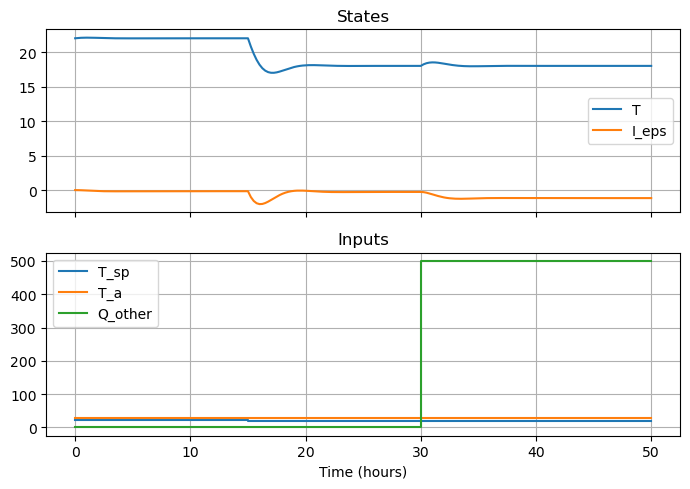

In [11]:
# Simulation inputs
nT = 200
t = dt * np.arange(nT+1)
X = np.full((nT+1, nx), np.nan)
U = np.zeros((nT+1, nu))
U[:, 0] = 22.0   # T_sp
U[t >= 15, 0] = 18.0   # T_sp
U[:, 1] = 28.0  # T_a
U[t >= 30, 2] = 500.0   # Q_other

# Initial condition
x0 = cas.vertcat(
    22.0,  # zone temperature
    0.0  # integral of tracking error
)

# Simulation loop
X = simulate_system(F, U, nx, x0)

# Plot results
make_inputs_states_plot(t, X, U, x_labels=['T', 'I_eps'], u_labels=['T_sp', 'T_a', 'Q_other'])
plt.tight_layout()
plt.show()

In [12]:
rmse_tracking = np.sqrt(np.mean((X[:, 0] - U[:, 0]) ** 2))
print(f"Tracking error: {rmse_tracking:.2f}")

Tracking error: 0.42


## Simulate multiple zones with cooling, disturbance inputs and PI controllers

States and inputs:

$$
\mathbf{x}(t) = \begin{bmatrix}
    T_1(t) \\ \vdots \\ T_{n_z}(t) \\ 
    \bar{\varepsilon}_1(t) \\ \vdots \\ \bar{\varepsilon}_{n_z}(t) \\
\end{bmatrix},
\mathbf{u}(t) = \begin{bmatrix}
    T_{sp,1} \\ \vdots \\ T_{sp,n_z} \\ 
    \dot{Q}_{\text{other},1} \\ \vdots \\ \dot{Q}_{\text{other},n_z} \\
    T_a
\end{bmatrix}
$$

In [38]:
nz = 4

# Constants
C = cas.DM([450.0, 450.0, 450.0, 450.0])  # thermal capacitance, kJ/K
H = cas.DM([15.0, 15.0, 15.0, 15.0])  # scaled heat transfer coefficient with ambient, kW/K
K_c = cas.DM([-560, -560, -560, -560])  # controller gain parameter
tau_I = cas.DM([1, 1, 1, 1])  # PI controller integral parameter
Q_ss = cas.DM([0, 0, 0, 0])  # steady-state rate of cooling

# beta[i, j] is the heat transfer coefficient between zones i and j, kW/K
#
# Room layout:
# ---------
# | 0 | 1 |
# ---------
# | 2 | 3 |
# ---------
#
beta = cas.DM([
    [0. , 0.5, 0.5, 0. ],
    [0.5, 0. , 0. , 0.5],
    [0.5, 0. , 0. , 0.5],
    [0. , 0.5, 0.5, 0. ]
])

# System dimensions
nx = 2 * nz
nu = 2 * nz + 1

# States
x = cas.MX.sym('x', nx)
u = cas.MX.sym('x', nu)

T = x[:nz]  # zone temperatures
I_eps = x[nz:2*nz]  # integral of tracking error
T_sp = u[:nz]  # zone temperature setpoint
Q_other = u[nz:2*nz]  # external heat load, e.g. insolation or disturbance
T_a = u[2*nz]  # ambient temperature

# Define ODE
eps = T_sp - T  # tracking error
dI_eps_dt = eps
Q_c = Q_ss + K_c * (eps + I_eps / tau_I)  # control action
dTdt = (-H * (T - T_a) - Q_c + Q_other) / C  # rate-of-change of zone temperature

# Add interactive effects
for i in range(nz):
    for j in range(nz):
        if j == i or beta[i, j] == 0.0:
            continue
        dTdt[i] = dTdt[i] - beta[i, j] * (T[i] - T[j]) 

rhs = cas.vertcat(dTdt, dI_eps_dt)
f = cas.Function('f', [x, u], [rhs], ['x', 'u'], ['dxdt'])
print(f)

f:(x[8],u[9])->(dxdt[8]) MXFunction


In [39]:
# Construct discrete-time system model
dt = 0.25  # timestep size, hours
F = convert_continuous_model_to_discrete(f, x, u, dt)
print(F)

F:(xk[8],uk[9])->(xkp1[8]) MXFunction


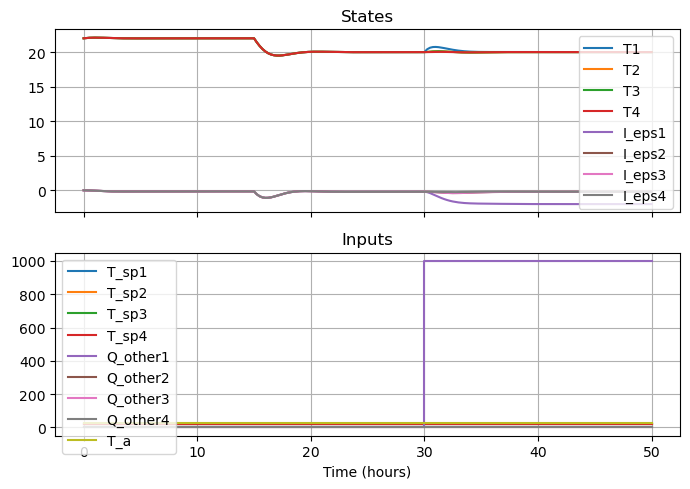

In [40]:
# Simulation inputs
nT = 200
t = dt * np.arange(nT+1)
X = np.full((nT+1, nx), np.nan)
U = np.zeros((nT+1, nu))
U[:, 0] = 22.0   # T_sp1
U[:, 1] = 22.0   # T_sp2
U[:, 2] = 22.0   # T_sp3
U[:, 3] = 22.0   # T_sp4
U[t >= 15, 0:4] = 20.0  # Change all T_sp
U[t >= 30, 4] = 1000.0   # Q_other1
U[t >= 30, 5] = 0.0   # Q_other2
U[t >= 30, 6] = 0.0   # Q_other3
U[t >= 30, 7] = 0.0   # Q_other4
U[:, 8] = 28.0  # T_a

# Initial condition
x0 = cas.vertcat(
    22.0,  # T1
    22.0,  # T2
    22.0,  # T3
    22.0,  # T4
    0.0,   # I_eps1
    0.0,   # I_eps2
    0.0,   # I_eps3
    0.0,   # I_eps4
)

# Simulation loop
X = simulate_system(F, U, nx, x0)

# Plot results
x_labels = (
    [f'T{i+1}' for i in range(nz)] 
    + [f'I_eps{i+1}' for i in range(nz)]
)
u_labels = (
    [f'T_sp{i+1}' for i in range(nz)] 
    + [f'Q_other{i+1}' for i in range(nz)]
    + ['T_a']
)
make_inputs_states_plot(t, X, U, x_labels=x_labels, u_labels=u_labels)
plt.tight_layout()
plt.show()

In [41]:
rmse_tracking = np.sqrt(np.mean((X[:, 0:nz] - U[:, 0:nz]) ** 2))
print(f"Tracking error: {rmse_tracking:.2f}")

Tracking error: 0.22


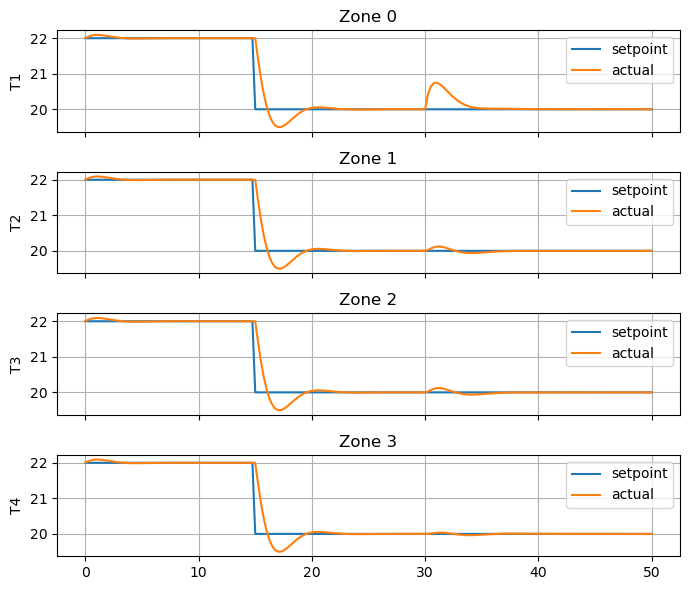

In [42]:
fig, axes = plt.subplots(nz, 1, sharex=True, figsize=(7, 6))
for z, ax in enumerate(axes):
    ax.plot(t, U[:, z], label='setpoint')
    ax.plot(t, X[:, z], label='actual')
    ax.grid()
    ax.set_ylabel(f"T{z+1}")
    ax.legend()
    ax.set_title(f"Zone {z}")
axes[-1].set_label("Time (hours)")
plt.tight_layout()
plt.show()
    

In [43]:
from prettytable import PrettyTable
table = PrettyTable()
table.add_column("Time", t)
for i in range(nz):
    table.add_column(f"T{i+1}", X[:, i].round(2))
table

Time,T1,T2,T3,T4
0.0,22.0,22.0,22.0,22.0
0.25,22.04,22.04,22.04,22.04
0.5,22.07,22.07,22.07,22.07
0.75,22.09,22.09,22.09,22.09
1.0,22.09,22.09,22.09,22.09
1.25,22.09,22.09,22.09,22.09
1.5,22.08,22.08,22.08,22.08
1.75,22.07,22.07,22.07,22.07
2.0,22.06,22.06,22.06,22.06
2.25,22.05,22.05,22.05,22.05


## Data from Stanford Case Study

This data was made available from:
- https://hvacstudy.github.io/

In [19]:
data_dir = "data"
filename = "data.mat"

data = scipy.io.matlab.loadmat(os.path.join(data_dir, filename), simplify_cells=True)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'param', 'airside', 'waterside'])

In [20]:
{name: type(x) for name, x in data.items()}

{'__header__': bytes,
 '__version__': str,
 '__globals__': list,
 'param': dict,
 'airside': dict,
 'waterside': dict}

In [21]:
param = data['param']
param.keys()

dict_keys(['time', 'AmbientTemp', 'ElecPrices', 'DemandCharge', 'ComfortMin', 'ComfortMax', 'StorageCapacity'])

In [22]:
airside = data['airside']
airside.keys()

dict_keys(['H', 'C', 'Beta', 'Qss', 'Kc', 'tauI'])

In [23]:
waterside = data['waterside']
waterside.keys()

dict_keys(['common', 'chiller', 'pump', 'tower', 'tank'])

In [24]:
n_buildings = 25
assert data['airside']['C'].shape[0] == n_buildings

n_zones = 20
assert all([x.shape[0] for x in data['airside']['C']])


In [25]:
# Example of airside coefficients
building = 0
zone = 9
{p: airside[p][building][zone] for p in ['H', 'C', 'Qss', 'Kc', 'tauI']}

{'H': 15.14116470241531,
 'C': 438.2875387003527,
 'Qss': 0,
 'Kc': -560,
 'tauI': 1}

In [26]:
airside['Beta'][building][zone]

array([0.14570582, 0.13657539, 0.15410582, 0.15091977, 0.15063744,
       0.150666  , 0.14805606, 0.14147962, 0.14821616, 0.        ,
       0.14741695, 0.14932725, 0.14824992, 0.14464378, 0.14673437,
       0.14295033, 0.14881521, 0.14169108, 0.14196478, 0.14287258])

In [27]:
# Why are all the zones coupled almost equally?